In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300

import importlib.util
import os
import csv

import warnings
warnings.filterwarnings('ignore')

from scipy import cluster, stats, optimize
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.stats import hypergeom
import Levenshtein
import sqlite3

from smer import load_smer_data, sdist_kmers, sdist_seq, colors


In [2]:
## datasets
folder = '../data/'

# Data
fn1 = 'orit_query_data.csv'
fn2 = 'host_p4600_data.csv'
fn3 = 'filtered_orit_hits.csv'
fn4 = 'query_60_to_nic.irs_6bp_mis2.csv'
fn5 = 'coeffs_s7_c128.csv'
fn6 = 'cds.csv'
fn7 = 'dframe_plasmid_cds_stacked.csv'
fn8 = 'seqid_region_size.csv'
fn9 = 'query_seqid_region_size.csv'
smer_dir = folder


In [3]:
# functions

# https://blog.algorexhealth.com/2018/03/almost-10-pie-charts-in-10-python-libraries/=
def group_lower_ranking_values(pie_raw, column):
    pie_counts = pie_raw.groupby(column).agg('count')
    pct_value = pie_counts[lambda df: df.columns[0]].quantile(.75)
    values_below_pct_value = pie_counts[lambda df: df.columns[0]].loc[lambda s: s < pct_value].index.values
    def fix_values(row):
        if row[column] in values_below_pct_value:
            row[column] = 'Other'
        return row 
    pie_grouped = pie_raw.apply(fix_values, axis=1).groupby(column).agg('count')
    return pie_grouped

#https://www.pythonprogramming.in/how-to-pie-chart-with-different-color-themes-in-matplotlib.html
def plot_pyplot_pie(series):
    # Data to plot
    labels = series.index.values
    sizes = series.values
    #colors = 'Paired'#['grey','lightcoral']
    #explode = (0, 0.1)  # explode 1st slice

    # Plot
    theme = plt.get_cmap('Greys')
    ax.set_prop_cycle("color", [theme(1. * i / len(series))
                             for i in range(len(series))])

    pltdat = ax.pie(sizes,  labels=labels, autopct='%1.1f%%', #explode=explode,
            shadow=False, startangle=135, #colors=colors,
            counterclock=False)

    #plt.axis('equal')
    #     for w in pltdat[0]:
    #         w.set_linewidth(2)
    #         w.set_edgecolor('white')
    
def print_values(col1):
    print(p4600[col1].unique().shape)
    print(p4600[p4600.mob_relax==1][col1].unique().shape)
    print(p4600[p4600.mob_orit==1][col1].unique().shape)
    print(p4600[p4600.mob_all==1][col1].unique().shape)
    print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)][col1].unique().shape[0])
    print(p4600[p4600.mob_all==1][col1].unique().shape[0]-p4600[p4600.mob_relax==1][col1].unique().shape[0])

    print(p4600[p4600.mob_relax==1][col1].unique().shape[0]/p4600[col1].unique().shape[0])
    print(p4600[p4600.mob_orit==1][col1].unique().shape[0]/p4600[col1].unique().shape[0])
    print(p4600[p4600.mob_all==1][col1].unique().shape[0]/p4600[col1].unique().shape[0])
    print(p4600[p4600.mob_all==1][col1].unique().shape[0]/p4600[p4600.mob_relax==1][col1].unique().shape[0])    
    
def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

def corrfunc(x, y, **kws):
    (r, p) = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.3f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.1e}".format(fix_pvals(p)),
                xy=(.45, .9), xycoords=ax.transAxes)
    
def get_pval_score_funV2(x,coeffs):
    '''converts s-distance scores to p-values'''
    # reformat coeffs
    p = np.zeros((5,1))
    p[1:] = coeffs
    # compute
    y = p[1]*np.power(x,2) + p[2]*x + p[3]
    y[y >= p[4]] = -1 # ~(score < p1(4))
    return y

def get_score_pval_funV2(y,coeffs):
    '''converts p-values to s-distance scores'''
    # reformat coeffs
    p = np.zeros((5,1))
    p[1:] = coeffs
    # compute
    x = (-p[2]+np.sqrt(np.power(p[2],2)-4*p[1]*(p[3]-y)))/(2*p[1])
    x = np.real(x);
    # fot only to 1e-1 so this is asserted cutoff
    x[x > p[4]] = p[4] # vectorized
    return x    

def dframe_stack_list(ins,col):
    df = ins.copy(deep=True)
    s = df[col].apply(lambda x: pd.Series(list(x)),1).stack()
    s.index = s.index.droplevel(-1)
    s.name = col
    del df[col]
    df = df.join(s)
    return df

def get_product_groups(df):
    
    df_cds4 = df.copy(deep=True)
    # fix all none nan to str 'none'
    df_cds4['product'].fillna(value='None',inplace=True)

    # count specifically:
    # hypothetical protein / Hypothetical protein
    # cotaining word transposase
    # containing word integrase
    # containig word conj (ie conjugal, conjugation, trw, 
    # all names linked to conjugation - find)
    # containing word island
    #df_cds4.groupby('product').plasmid_id.count().sort_values(ascending=False)

    df_cds4['product2'] = 'None'

    ind1 = ((df_cds4['product']=='None')==False)
    df_cds4['product2'][ind1] = 'Other'

    ind1 = ((df_cds4['product'].str.contains('hypothetical protein'))|
        (df_cds4['product'].str.contains('Hypothetical protein')))
    df_cds4['product2'][ind1] = 'Hypothetical protein'

#     ind1 = ((df_cds4['product'].str.contains('island'))|
#             (df_cds4['product'].str.contains('Island')))
#             (df_cds4['product'].str.contains('transfer'))|
#             (df_cds4['product'].str.contains('Transfer')))
#     df_cds4['product2'][ind1] = 'Other mobility'

    ind1 = ((df_cds4['product'].str.contains('transpos'))|
        (df_cds4['product'].str.contains('Transpos')))
    df_cds4['product2'][ind1] = 'Transposition'

    ind1 = ((df_cds4['product'].str.contains('integra'))|
        (df_cds4['product'].str.contains('Integra')))
    df_cds4['product2'][ind1] = 'Integration'

    ind1 = ((df_cds4['product'].str.contains('conjug'))|
            (df_cds4['product'].str.contains('Conjug'))|
            (df_cds4['product'].str.contains('trw'))|
            (df_cds4['product'].str.contains('Trw'))|
            (df_cds4['product'].str.contains('relax'))|
            (df_cds4['product'].str.contains('Relax'))|
            (df_cds4['product'].str.contains('mob'))|
            (df_cds4['product'].str.contains('Mob')))
    df_cds4['product2'][ind1] = 'Conjugation'

    return df_cds4
    
def func(x, a, b, c):
    return a * np.log(b * x) + c

def func_inv(y, a, b, c):
    return np.exp((y - c)/a)/b

def func1(x, a, b):
    return a * x + b

def func1_inv(y, a, b):
    return (y - b)/a

# https://stackoverflow.com/questions/39434402/how-to-get-confidence-intervals-from-curve-fit
def get_fit_results(func1,func1_inv):
    popt, pcov = optimize.curve_fit(func1,np.log(xdata),ydata,sigma=ystd)
    perr = np.sqrt(np.diag(pcov))
    fit.append([popt,perr])

    # plot
    plt.figure(figsize=(4,3))
    plt.scatter(xdata,ydata,color='k',marker='o',s=10)
    plt.errorbar(xdata,ydata,yerr=ystd,
                 color='k',marker='o',elinewidth=1,fmt='none')
    
    plt.plot(xdata2, func1(np.log(xdata2), *popt), 'r-',zorder=0)
    plt.scatter(np.exp(func1_inv(points[k], *popt)),points[k],
                color='k',marker='x')
    
    xerr=[np.exp(func1_inv(points[k], *(popt + 1.96*perr/np.sqrt(10)))),
          np.exp(func1_inv(points[k], *(popt - 1.96*perr/np.sqrt(10))))]
    plt.plot(xerr,[points[k],points[k]],
                 color='k',linewidth=1)
    print(np.exp(func1_inv(points[k], *popt)),
          xerr
         )

    # plotting the confidence intervals
    bound_upper = func1(np.log(xdata2), *(popt + 1.96*perr/np.sqrt(10)))
    bound_lower = func1(np.log(xdata2), *(popt - 1.96*perr/np.sqrt(10)))
    plt.fill_between(xdata2, bound_lower, bound_upper,
                 color = 'black', alpha = 0.15)
    
    plt.xscale('log')
    plt.xlabel('Size of oriT query dataset')
    plt.ylabel(ylabels[k])
    plt.show()

    return fit


## Plasmid mobility

In [4]:
# load data

# query data
df_query = pd.read_csv(folder+fn1, sep=';')
df_query.head()

# p4600 data
p4600 = pd.read_csv(folder+fn2,sep=';')
p4600.reset_index(inplace=True)
p4600.head()

# merge multiples of same group into one
mob2 = []
for x in p4600.Mob.values:
    if x in ['Q','QQ','QQQ']:
        mob2.append('Q')
    elif x in ['V','VV','VVV']:
        mob2.append('V')
    elif x in ['-']:
        mob2.append('Not found')
    elif x in ['CF','FP','HV','PQ','PV','QV']:
        mob2.append('Multiple')
    else:
        mob2.append(x)
    
p4600['Mob_relax'] = mob2

# load df4
df4 = pd.read_csv(folder+fn3)


Text(0, 0.5, 'Counts')

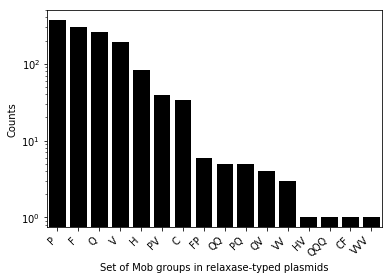

In [5]:
# mob groups distrubution
tmp = (p4600[p4600['Is_Mob?']==1]
       .Mob
       .value_counts()
       .reset_index()
      )

sns.barplot(data=tmp,
            x='index',y='Mob',color='k')
plt.xticks(rotation=45,ha='right')
plt.yscale('log')
plt.xlabel('Set of Mob groups in relaxase-typed plasmids')
plt.ylabel('Counts')


In [6]:
# mark a new column in p4600 combining both mobility types
# in order to assess full mobility
p4600['mob_relax'] = p4600['Is_Mob?']
p4600['mob_orit'] = 0
p4600.loc[p4600.Genbank.isin(df4.plasmid_id),'mob_orit'] = 1
p4600['mob_all'] = 0
p4600.loc[p4600.Genbank.isin(df4.plasmid_id),'mob_all'] = 1
p4600.loc[p4600['Is_Mob?']==1,'mob_all'] = 1

# Sanity check
print(all(p4600[p4600.mob_orit==1].Genbank.isin(p4600[p4600.mob_all==1].Genbank)))
print(all(p4600[p4600.mob_relax==1].Genbank.isin(p4600[p4600.mob_all==1].Genbank)))

# plasmids
print_values('Genbank')
# print_values('Species')
# print_values('Genus')
# print_values('Phylum')

True
True
(4602,)
(1309,)
(2084,)
(2486,)
907
1177
0.2844415471534116
0.4528465884398088
0.540199913081269
1.8991596638655461


In [7]:
# Values for figure 2B additional

print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)]
            .Species
            .unique()
            .shape
            )
print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)]
            .Genbank
            .unique()
            .shape
            )

print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==0)]
            .Species
            .unique()
            .shape
            )
print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==0)]
            .Genbank
            .unique()
            .shape
            )

print(p4600[(p4600.mob_orit==0)&(p4600.mob_relax==1)]
            .Species
            .unique()
            .shape
            )
print(p4600[(p4600.mob_orit==0)&(p4600.mob_relax==1)]
            .Genbank
            .unique()
            .shape
            )

print(p4600[(p4600.mob_orit==0)&(p4600.mob_relax==0)]
            .Species
            .unique()
            .shape
            )
print(p4600[(p4600.mob_orit==0)&(p4600.mob_relax==0)]
            .Genbank
            .unique()
            .shape
            )

print(p4600
            .Species
            .unique()
            .shape
            )
print(p4600
            .Genbank
            .unique()
            .shape
            )

print(p4600[(p4600.mob_all==1)]
            .Species
            .unique()
            .shape
            )
print(p4600[(p4600.mob_all==1)]
            .Genbank
            .unique()
            .shape
            )

(254,)
(907,)
(387,)
(1177,)
(170,)
(402,)
(519,)
(2116,)
(893,)
(4602,)
(607,)
(2486,)


In [8]:
## Obtain grouping of Mob groups
# Mob2 .. mob groups of relaxase-typed
# Mob_orit .. mob groups of orit hits

tmp = (df4
 .groupby('plasmid_id')
 .mob
 .apply(lambda x: ''.join(np.unique(x)))
)
tmp = (pd
       .DataFrame(tmp)
       .reset_index()
       .rename(columns={'mob':'Mob_orit'})
      )

#p4600['Mob_orit'] = 'Not found'
p4600 = (p4600.merge(tmp,
                   left_on='Genbank',
                   right_on='plasmid_id',
                   how='left')
         .drop(columns=['plasmid_id'])
         .fillna(value={'Mob_orit':'Not found'})
        )

p4600.head()

# In how many overlapping orit hits and relaxase-typed
# plasmids also same Mob group found?

p4600.loc[(p4600.mob_orit==1)&(p4600.mob_relax==1),'Mob_overlap'] = (p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)]
 .apply(lambda x: len(''.join(set(x.Mob_relax).intersection(x.Mob_orit))),axis=1)
)
p4600['Mob_overlap'] = p4600.Mob_overlap.fillna(0).astype(int)
print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)].Mob_overlap.sum())
print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)].Mob_overlap.sum()/p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)].shape[0])


679
0.7486218302094818


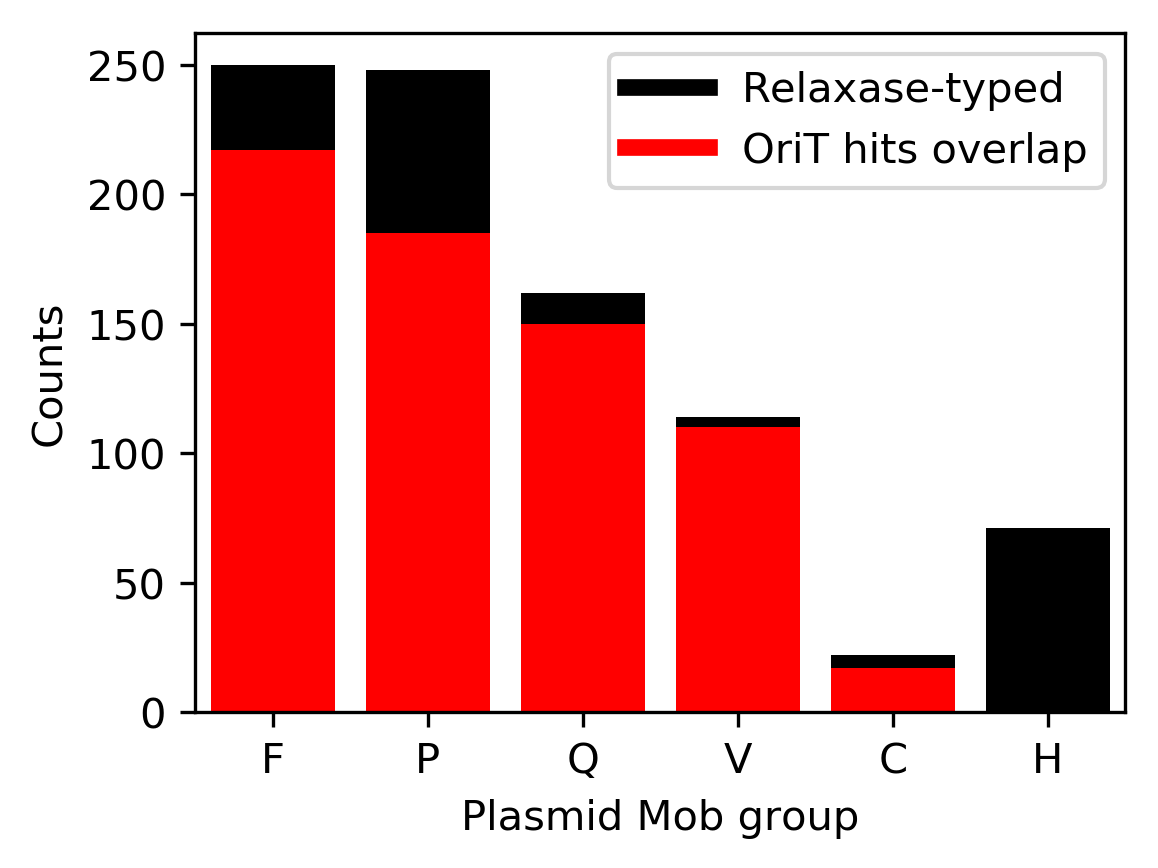

In [9]:
# plot overlap at diff mob groups

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
mob2 = []
for x in p4600.Mob.values:
    if x in ['Q','QQ','QQQ']:
        mob2.append('Q')
    elif x in ['V','VV','VVV']:
        mob2.append('V')
    elif x in ['-']:
        mob2.append('Not found')
    elif x in ['CF','FP','HV','PQ','PV','QV']:
        mob2.append('Multiple')
    else:
        mob2.append(x)
    
p4600['Mob_relax'] = mob2

tmp1 = (p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)]
        .groupby(['Mob_relax'])
        .Genbank.count()
        .reset_index()
       )
tmp2 = (p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)]
        .groupby(['Mob_overlap','Mob_relax'])
        .Genbank.count()
        .reset_index()
        .query("Mob_overlap==1")
       )

sns.barplot(data=tmp1,
           x='Mob_relax',y='Genbank',
            linewidth=0, facecolor='black',
           errcolor=".2", edgecolor=".2",
           order=['F','P','Q','V','C','H'])
sns.barplot(data=tmp2,
           x='Mob_relax',y='Genbank',
            linewidth=0, facecolor='red',
           errcolor=".2", edgecolor='red',
           order=['F','P','Q','V','C','H'])
plt.xlabel('Plasmid Mob group')
plt.ylabel('Counts')

# legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='r', lw=4)]

# fig, ax = plt.subplots()
# lines = ax.plot(data)
plt.legend(custom_lines, ['Relaxase-typed',
                         'OriT hits overlap'],
          loc='upper right')


plt.savefig('f2e.svg')


In [10]:
## Num orits

tmp = (df4
 .groupby('plasmid_id')
 .orit_index
 .count()
)
tmp = (pd
       .DataFrame(tmp)
       .reset_index()
       .rename(columns={'orit_index':'Num_orit'})
      )

#p4600['Mob_orit'] = 'Not found'
p4600 = (p4600.merge(tmp,
                   left_on='Genbank',
                   right_on='plasmid_id',
                   how='left')
         .drop(columns=['plasmid_id'])
         .fillna(value={'Num_orit':0})
        )

p4600.head()


,index,Genbank,Plasmid_name,Strain,Species,Genus,Order,Class,Phylum,Kingdom,...,Putative transferabilitye,Is_Mob?,Mob,Mob_relax,mob_relax,mob_orit,mob_all,Mob_orit,Mob_overlap,Num_orit
0,0,NC_005326,Clostridium difficile plasmid pCD6,Clostridioides difficile (Clostridium difficile),Clostridioides difficile,Clostridioides,Clostridiales,Clostridia,Firmicutes,Bacteria,...,non-mob,0,-,Not found,0,0,0,Not found,0,0.0
1,1,NC_009926,Acaryochloris marina MBIC11017 plasmid pREB1,Acaryochloris marina MBIC11017,Acaryochloris marina,Acaryochloris,Chroococcales,-,Cyanobacteria,Bacteria,...,mob,1,F,F,1,1,1,FPQV,1,5.0
2,2,NC_009927,Acaryochloris marina MBIC11017 plasmid pREB2,Acaryochloris marina MBIC11017,Acaryochloris marina,Acaryochloris,Chroococcales,-,Cyanobacteria,Bacteria,...,mob,1,F,F,1,1,1,FQ,1,2.0
3,3,NC_009928,Acaryochloris marina MBIC11017 plasmid pREB3,Acaryochloris marina MBIC11017,Acaryochloris marina,Acaryochloris,Chroococcales,-,Cyanobacteria,Bacteria,...,mob,1,F,F,1,1,1,Q,0,1.0
4,4,NC_009929,Acaryochloris marina MBIC11017 plasmid pREB4,Acaryochloris marina MBIC11017,Acaryochloris marina,Acaryochloris,Chroococcales,-,Cyanobacteria,Bacteria,...,mob,1,F,F,1,0,1,Not found,0,0.0


In [11]:
# average num orit
# relaxase typed
print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)]
 .Num_orit
 .describe()
)
print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==0)]
 .Num_orit
 .describe()
)
print(p4600[(p4600.mob_orit==1)]
 .Num_orit
 .describe()
)

print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)]
 .Num_orit
 .apply(lambda x: x<2)
 .sum()/
      p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)].shape[0]
)
print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)]
 .Num_orit
 .apply(lambda x: x>1)
 .sum()/
      p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)].shape[0]
)

print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==0)]
 .Num_orit
 .apply(lambda x: x<2)
 .sum()/
      p4600[(p4600.mob_orit==1)&(p4600.mob_relax==0)].shape[0]
)
print(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==0)]
 .Num_orit
 .apply(lambda x: x>1)
 .sum()/
      p4600[(p4600.mob_orit==1)&(p4600.mob_relax==0)].shape[0]
)

count    907.000000
mean       4.183021
std        5.011204
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       33.000000
Name: Num_orit, dtype: float64
count    1177.000000
mean        6.544605
std         8.272049
min         1.000000
25%         1.000000
50%         2.000000
75%         9.000000
max        45.000000
Name: Num_orit, dtype: float64
count    2084.000000
mean        5.516795
std         7.136231
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max        45.000000
Name: Num_orit, dtype: float64
0.36934950385887544
0.6306504961411246
0.35514018691588783
0.6448598130841121


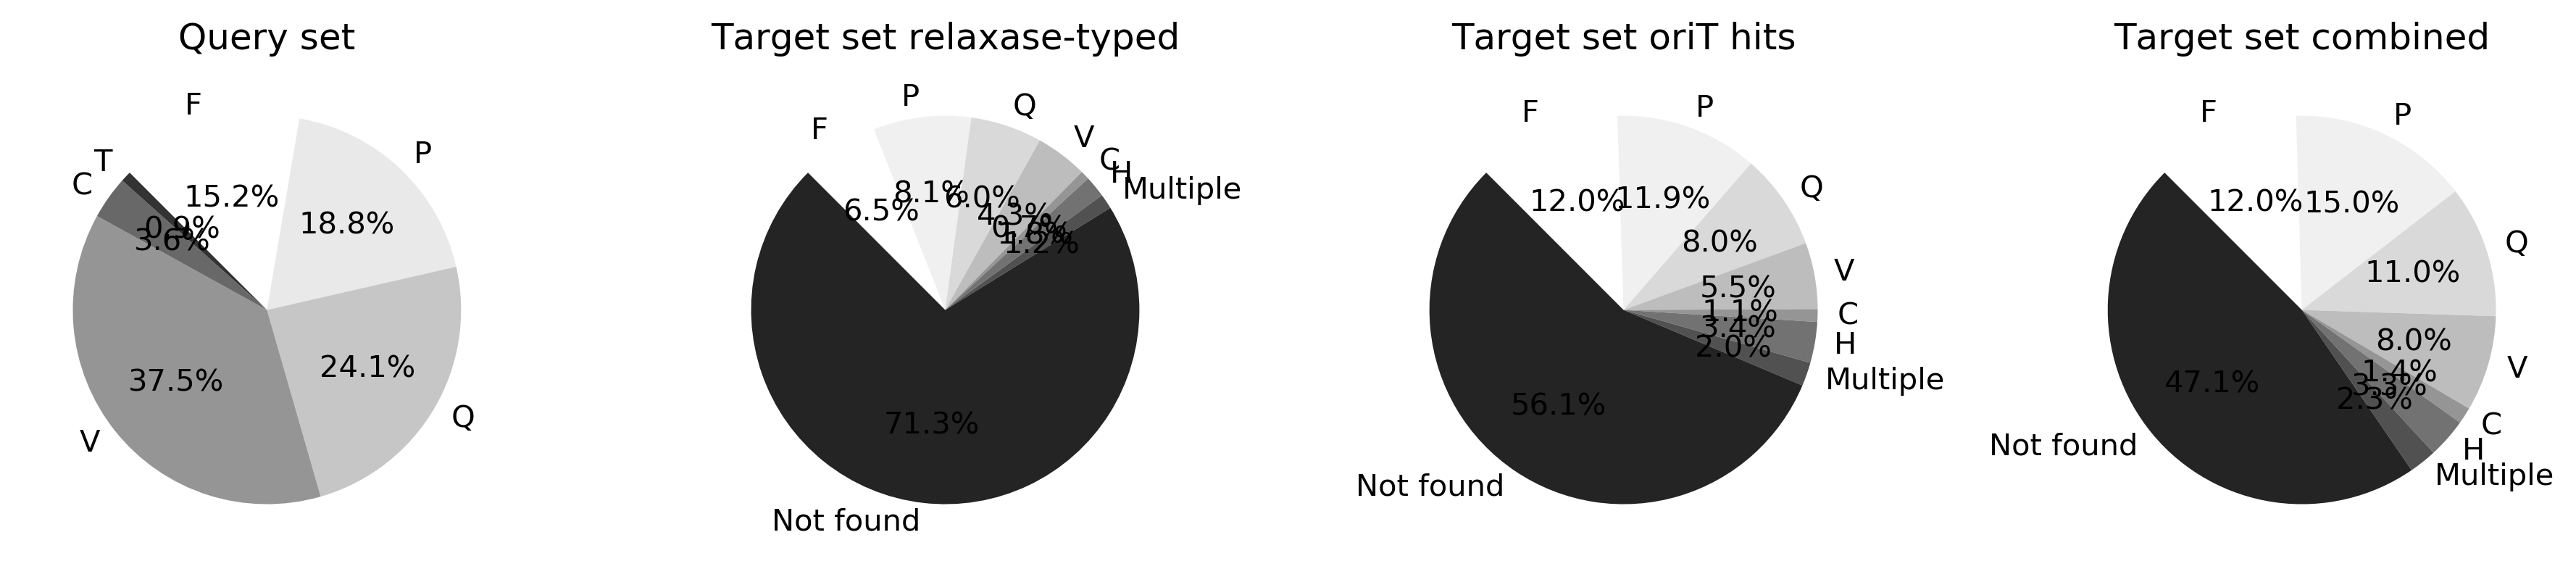

In [12]:
# Separate plots mob groups

# # Pie chart - num sequences
  
#plt.rcParams["image.cmap"] = "twilight"
    
f2 = plt.figure(figsize=(12,4))

ax = plt.subplot(1, 4, 1)
series = (df_query
          .groupby('Mob')['Plasmid_name']
          .count()
          .loc[['F','P','Q','V','C','H','T']]
          .dropna())
plot_pyplot_pie(series)
plt.ylabel('')
plt.title('Query set')

ax = plt.subplot(1, 4, 2)
series = (p4600
                   .groupby('Mob_relax')['index']
                   .count()
                   .loc[['F','P','Q','V','C','H','Multiple','Not found']]
                  )
plot_pyplot_pie(series)
plt.ylabel('')
plt.title('Target set relaxase-typed')

ax = plt.subplot(1, 4, 3)

series = (p4600[p4600.mob_orit==1]
                   .groupby('Mob_relax')['index']
                   .count()
                   .loc[['F','P','Q','V','C','H','Multiple','Not found']]
                  )
plot_pyplot_pie(series)
plt.ylabel('')
plt.title('Target set oriT hits')

ax = plt.subplot(1, 4, 4)
series = (p4600[p4600.mob_all==1]
                   .groupby('Mob_relax')['index']
                   .count()
                   .loc[['F','P','Q','V','C','H','Multiple','Not found']]
                  )
plot_pyplot_pie(series)
plt.ylabel('')
plt.title('Target set combined')

plt.tight_layout()
plt.savefig('f2a.svg')


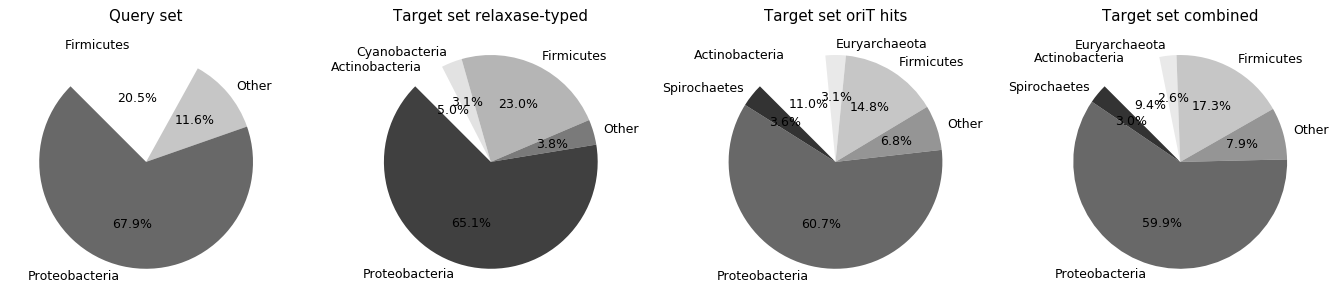

In [13]:
# Separate plots phylum distributions

mpl.rcParams['figure.dpi'] = 90
f2 = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 4, 1)
df_phylum = group_lower_ranking_values(df_query,'Phylum') 
series = df_phylum.Plasmid_name
plot_pyplot_pie(series)
plt.ylabel('')
plt.title('Query set')

ax = plt.subplot(1, 4, 2)
df_phylum = group_lower_ranking_values(p4600[p4600.mob_relax==1],'Phylum')
series = df_phylum.Plasmid_name
plot_pyplot_pie(series)
plt.ylabel('')
plt.title('Target set relaxase-typed')

ax = plt.subplot(1, 4, 3)
df_phylum = group_lower_ranking_values(p4600[p4600.mob_orit==1],'Phylum')
series = df_phylum.Plasmid_name
plot_pyplot_pie(series)
plt.ylabel('')
plt.title('Target set oriT hits')

ax = plt.subplot(1, 4, 4)
df_phylum = group_lower_ranking_values(p4600[p4600.mob_all==1],'Phylum')
series = df_phylum.Plasmid_name
plot_pyplot_pie(series)
plt.ylabel('')
plt.title('Target set combined')

plt.tight_layout()
plt.show()

In [14]:
# distribution of mob groups across plasmids
# chapter 3

# Count Mob groups 
print(sum(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)]
 .Mob_orit
 .apply(lambda x: len(x)>1)/
          p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)].shape[0])
     )
print(sum(p4600[(p4600.mob_orit==1)&(p4600.mob_relax==0)]
 .Mob_orit
 .apply(lambda x: len(x)>1)/
          p4600[(p4600.mob_orit==1)&(p4600.mob_relax==1)].shape[0])
     )

p4600['Num_mob'] = 0
p4600.loc[p4600.mob_orit==1,'Num_mob'] = (p4600[(p4600.mob_orit==1)]
                                             .Mob_orit
                                             .apply(lambda x: len(x))
                                         )

0.534729878721056
0.704520396912904


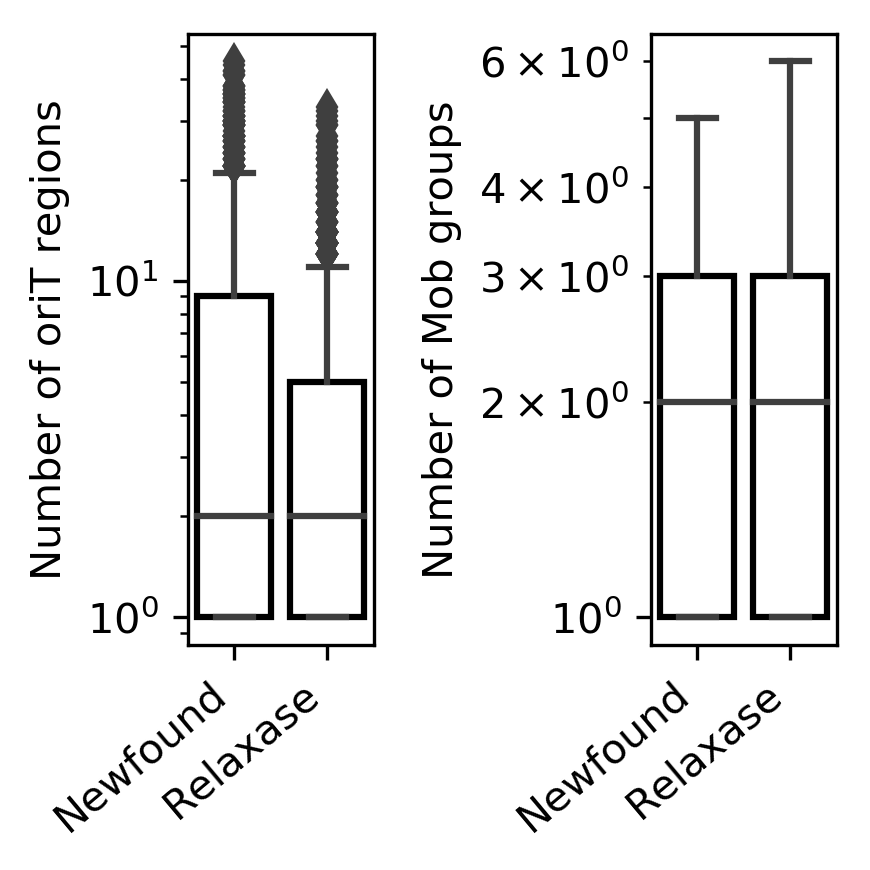

In [15]:
# Plot num orit num mob groups
# separate relaxase/ newfound

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
plt.subplot(1,2,1)
ax = sns.boxplot(data=p4600[p4600.mob_orit==1],
                 x='mob_relax',y='Num_orit')
plt.yscale('log')
plt.xlabel('')
ax.set_xticklabels(['Newfound','Relaxase'])
#ax.set_yticklabels((1,10),('1','10'))
plt.ylabel('Number of oriT regions')

for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
plt.xticks(rotation=40,ha="right")

plt.subplot(1,2,2)
ax = sns.boxplot(data=p4600[p4600.mob_orit==1],
                 x='mob_relax',y='Num_mob')
plt.yscale('log')
plt.xlabel('')
ax.set_xticklabels(['Newfound','Relaxase'])
#ax.set_yticklabels(['1','2','3','4','6'])
plt.ylabel('Number of Mob groups')

for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
plt.xticks(rotation=40,ha="right")

plt.tight_layout()
plt.savefig('f2f.svg')


## Sequence analysis

6
10.0


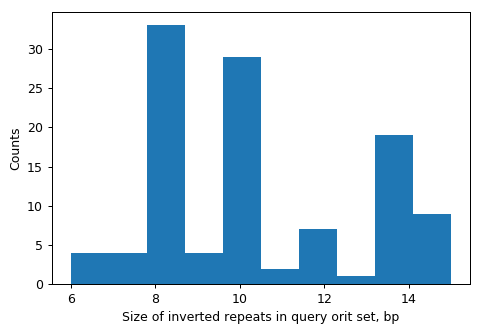

In [16]:
# Inv. repeat analysis

# query
query_irs = pd.read_csv(folder+fn4,header=None)

# find max ir sizes
irsize = (query_irs
 .apply(lambda x: list(np.where(x>0)[0]),axis=1)
 .apply(lambda x: max(x))
 .values
)
print(min(irsize)+6)

# hist of largest ir size per orit
mpl.rcParams['figure.dpi'] = 90
plt.hist([x+6 for x in irsize], bins=10)
plt.ylabel('Counts')
plt.xlabel('Size of inverted repeats in query orit set, bp')

print(np.median([x+6 for x in irsize]))

,count,mean,std,min,25%,50%,75%,max
mob,,,,,,,,
C,351.0,9.863248,2.204823,6.0,8.0,10.0,12.0,14.0
F,1745.0,10.198281,2.303940,6.0,8.0,10.0,12.0,15.0
P,831.0,10.087846,1.956942,6.0,8.0,10.0,11.0,15.0
Q,6867.0,10.026358,2.016327,6.0,8.0,10.0,12.0,15.0
T,1.0,8.000000,NaN,8.0,8.0,8.0,8.0,8.0
V,1702.0,10.449471,2.111411,6.0,9.0,10.0,12.0,15.0


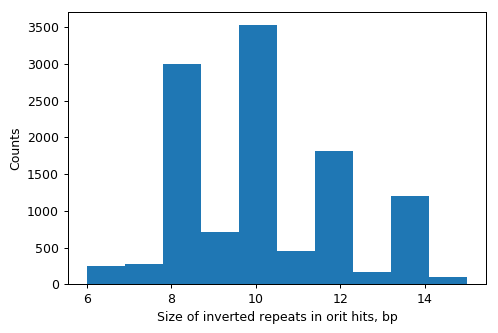

In [17]:
# orit hits

plt.hist(df4.ir_size, bins=10)
plt.ylabel('Counts')
plt.xlabel('Size of inverted repeats in orit hits, bp')

# across mob groups
(df4
 .groupby('mob')
 .ir_size
 .describe()
)


In [18]:
# result counts

df_res = pd.DataFrame(df4
                      .groupby(['mob','mob_subgroup'])
                      .plasmid_id
                      .count()
                     )
df_res.columns = ['orit_hits']
df_res['query_orits'] = (df_query
                         .groupby(['Mob','Mob subgroup'])
                         .Plasmid_name
                         .count()
                        )
df_res[['query_orits','orit_hits']]

query_orits  orit_hits
mob mob_subgroup                        
C   1                       2        339
    2                       2         12
F   11                      6         82
    12                      9        149
    13                      1          2
    u                       1       1512
P   11                      2         74
    12                      1         71
    13                      1         35
    14                      2         16
    2                       1          2
    3                       1         67
    4                       5        189
    5                       3        322
    6                       3         13
    7                       2         42
Q   1                       7        140
    2                       7       3264
    3                       3         29
    u                      10       3434
T   1                       1          1
V   1                      27        232
    2                       1       1371
    3                       2          1
    4                       6          5
    u                       6         93

0.55
0.9961381229886057


<Figure size 1200x900 with 0 Axes>

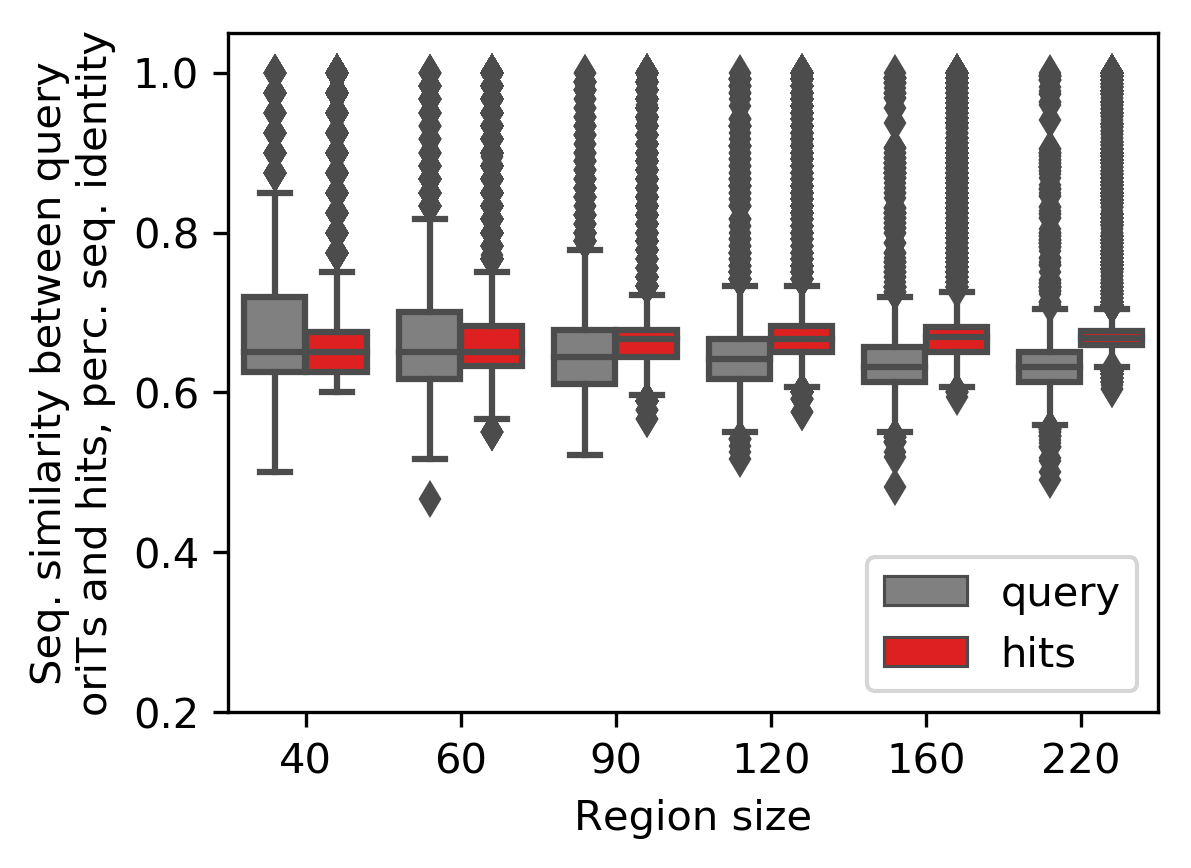

In [19]:
# Sequence similarity between queries and hits

strast_res = (pd.read_csv(folder+fn8)
              .set_index('Unnamed: 0')
             )
res = (pd.read_csv(folder+fn9)
       .set_index('mob')
      )

df4_plot = (df4.drop(columns=['seqid'])
               .merge(strast_res[['region_size','seqid']],
                      left_index=True,right_index=True,
                      how='left')
           )
# plot query and target
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
df_plot = res[(res.measure=='seqid')&(res.par_c==128)].reset_index()
df_plot = df_plot[df_plot.region_size>10][['region_size','value']]
df_plot['type'] = 'query'
tmp = (df4_plot[(df4_plot.region_size>10)][['region_size','seqid']]
         .rename(columns={'seqid':'value'})
        )
tmp['type'] = 'hits'

plt.figure(figsize=(4,3))
sns.boxplot(data=df_plot.append(tmp),
               x='region_size',y='value',
               hue='type',palette=['grey','r'])
#plt.plot([-10,100],[0.6,0.6],'r',linewidth=1,zorder=0)
plt.legend(loc=4)
plt.ylim(0.2,1.05)
plt.xlabel('Region size')
plt.ylabel('Seq. similarity between query\noriTs and hits, perc. seq. identity')
plt.savefig('f2d.svg')

print(df4_plot[df4_plot.region_size.isin([60,90,120,160,220])]
          .seqid
          .min()
          )

tmp = df4_plot[df4_plot.region_size.isin([60,90,120,160,220])]
tmp = df4_plot[df4_plot.region_size.isin([60,90,120,160,220])]
print(1-tmp[tmp.seqid<0.6].shape[0]/tmp.shape[0])


[1865.         1752.93152643 1505.68530852  277.07133752    7.85541049]
[  -1.05332947   -3.          -10.         -100.         -132.        ]


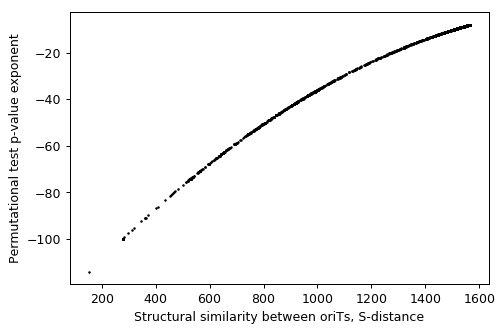

In [20]:
# Correlation between seq. id. and s-distance

# load coeffs
coeffs = pd.read_csv(folder+fn5,header=None).values.transpose()

print(get_score_pval_funV2([-1,-3,-10,-100,-132],coeffs))
print(get_pval_score_funV2([1865., 1752.93152643, 1505.68530852,  277.07133752,7.85541049],coeffs))

# Pearson correlation between seq id at diff sizes
# and s-distance

y = strast_res[strast_res.region_size==220].p_value.values
y2 = get_score_pval_funV2(y,coeffs)
y2.shape
pd.Series(y2).describe()

x = y2
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

mpl.rcParams['figure.dpi'] = 90
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.ylabel('Permutational test p-value exponent')
plt.xlabel('Structural similarity between oriTs, S-distance')
plt.show()


Text(0.5, 8.499999999999993, 'Structural similarity between query\noriTs and hits, s-distance')

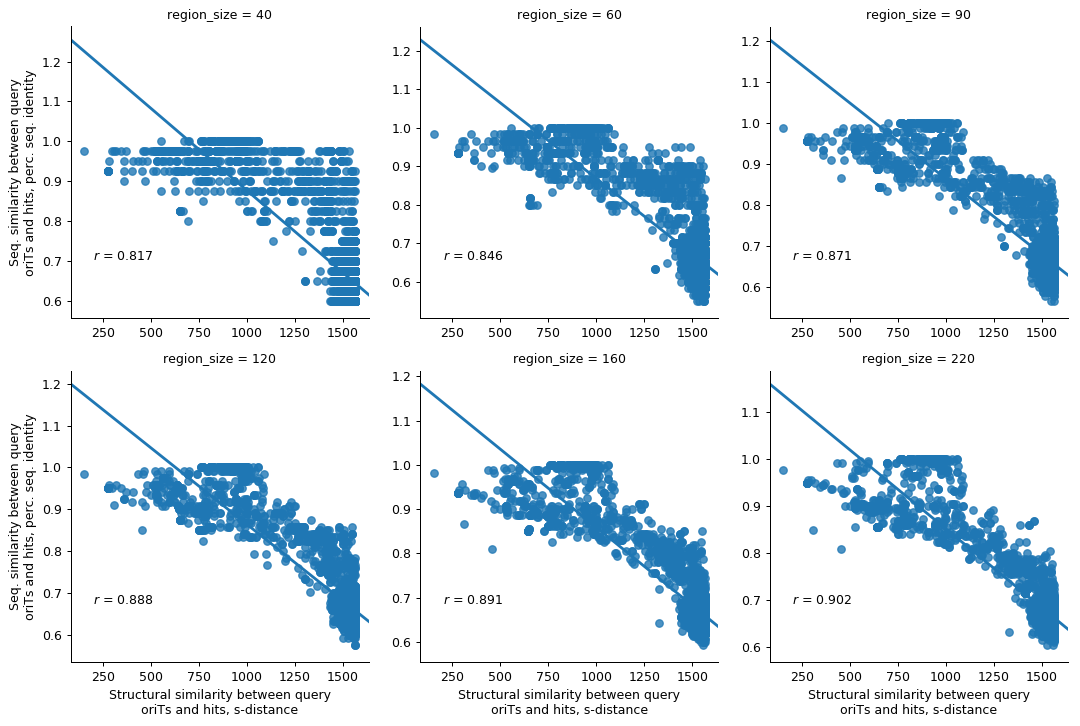

In [21]:
# supplementary fig

df4_plot['sdist'] = get_score_pval_funV2(df4_plot.p_value.values,coeffs)

g = sns.lmplot(data=df4_plot[df4_plot.region_size>10].rename(columns={'sdist':'S-distance',
                                           'seqid': 'Perc. seq identity'}),
           x='S-distance',y='Perc. seq identity',
           col='region_size',col_wrap=3,
            sharex=False,sharey=False,
            ci=None,size=4)

# correlation s-distance seqid
x = get_score_pval_funV2(df4.p_value.values,coeffs)
y = df4_plot[df4_plot.region_size==220].seqid.values

tmp = []
for siz in strast_res.region_size.unique():
    df4_plot.loc[df4_plot.region_size==siz,'sdist'] = x
    y = df4_plot[df4_plot.region_size==siz].seqid.values
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
    tmp.append([siz,slope,intercept,np.abs(rvalue),pvalue])
    
df_pcc = pd.DataFrame(tmp,
                      columns=['region_size','slope','intercept','rvalue','pvalue'])
# all p-values < 1e-16

# annotate each plot with r and p-val
df_pcc_tmp = df_pcc[(df_pcc.region_size>10)][:6]
k=1
for ax in g.axes:
    ax.annotate('$r$ = '+'%.3f'%(df_pcc_tmp.loc[k,'rvalue']),
                xy=(200,ax.get_ylim()[0]+0.2*np.diff(ax.get_ylim())))
    k+=1
    
g.axes.flat[0].set_ylabel('Seq. similarity between query\noriTs and hits, perc. seq. identity')
g.axes.flat[3].set_ylabel('Seq. similarity between query\noriTs and hits, perc. seq. identity') 
g.axes.flat[3].set_xlabel('Structural similarity between query\noriTs and hits, s-distance')
g.axes.flat[4].set_xlabel('Structural similarity between query\noriTs and hits, s-distance')
g.axes.flat[5].set_xlabel('Structural similarity between query\noriTs and hits, s-distance')


In [22]:
# correlation between sequence identities

tmp = []
sizes = df4_plot.region_size.unique()
for i in range(len(sizes)):
    for j in range(len(sizes)):
        x = df4_plot[df4_plot.region_size==sizes[i]].seqid.values
        y = df4_plot[df4_plot.region_size==sizes[j]].seqid.values
        slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
        tmp.append([sizes[i],sizes[j],slope,intercept,np.abs(rvalue),pvalue])
    
df_pcc2 = pd.DataFrame(tmp,
                      columns=['region_size1','region_size2','slope','intercept','rvalue','pvalue'])
print(df_pcc2.min())
(df_pcc2
 .query('region_size1.isin([40,60,90,120,160,220])')
 .query('region_size2.isin([40,60,90,120,160,220])')
 .set_index(['region_size1','region_size2'])
 .rvalue
 .unstack()
)


region_size1    10.000000
region_size2    10.000000
slope            0.496702
intercept       -0.138557
rvalue           0.729622
pvalue           0.000000
dtype: float64


region_size2,40,60,90,120,160,220
region_size1,,,,,,
40,1.000000,0.940277,0.916119,0.907978,0.889912,0.878428
60,0.940277,1.000000,0.955234,0.940295,0.925025,0.911239
90,0.916119,0.955234,1.000000,0.973206,0.959329,0.944463
120,0.907978,0.940295,0.973206,1.000000,0.979166,0.964006
160,0.889912,0.925025,0.959329,0.979166,1.000000,0.978883
220,0.878428,0.911239,0.944463,0.964006,0.978883,1.000000


## Orit location analysis of CDS records

In [23]:
# load data
# https://www.biostars.org/p/78386/
# ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/
df_cds = pd.read_csv(folder+fn6,
                    sep='\t').drop(columns=['note'])
# 37% genes have geneids
print(df_cds['db_xref'].unique().shape[0]/df_cds.shape[0])

df_cds.head()

# stack on list
# put all values to left and right col
df_cds2 = pd.read_csv(folder+fn7)

# filtered hits merge based on 
# nic location within our outside of genes
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge_asof.html

df_cds2['ind_left'] = (df_cds2
                       .ind_list
                       .apply(lambda x: int(x.split(' ')[0].replace("'","").replace('[','')))
                      )
df_cds2['ind_right'] = (df_cds2
                        .ind_list
                        .apply(lambda x: int(x.split(' ')[1].replace("'","").replace(']','')))
                       )
df_cds2.head()


0.36549233490566035


,location,gene,product,codon_start,indices,protein_id,db_xref,plasmid_id,ind_list,ind_left,ind_right
0,128..394,NaN,hypothetical protein,1,128 394,NP_957543.1,GeneID:4267664,NC_005326,['128' '394'],128,394
1,1155..1802,NaN,hypothetical protein,1,1155 1802,NP_957544.1,GeneID:4267665,NC_005326,['1155' '1802'],1155,1802
2,2077..3714,repA,RepA,1,2077 3714,NP_957545.1,GeneID:2716583,NC_005326,['2077' '3714'],2077,3714
3,complement(4778..5338),NaN,hypothetical protein,1,5338 4778,NP_957546.1,GeneID:4267662,NC_005326,['4778' '5338'],4778,5338
4,complement(5384..6457),NaN,hypothetical protein,1,6457 5384,NP_957547.1,GeneID:4267663,NC_005326,['5384' '6457'],5384,6457


In [24]:
#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
df4['orit_index'] = df4.index
df4.to_sql('A', conn, index=False)
df_cds2.to_sql('B', conn, index=False)

# only inner join possible based on location matching
qry = '''
select * 
from A
left join B on A.plasmid_id=B.plasmid_id
where A.nic_location >= B.ind_left and A.nic_location <= B.ind_right
''' 

#group by A.plasmid_id
#A.mob A.mob_subgroup A.p_value B.product B.protein_id
#A.query_index

df_cds3 = pd.read_sql_query(qry, conn)

# merge with ones outside genes (ie not returned by query)
df_cds4 = (df4
           .merge(df_cds3[['product','indices','protein_id','db_xref','orit_index']],
                          on='orit_index',how='left')
          )
print(df_cds4.shape)
df_cds4.head()


(11545, 18)


,nic_location,query_index,mob,mob_subgroup,p_value,plasmid_id,Genbank,p_cutoff,q-value,E-value,seqid,std_range,ir_size,orit_index,product,indices,protein_id,db_xref
0,184676,14,P,6,-8.9187,NC_009926,NC_009926,-8.0,1.605789e-110,0.001188,0.7,>=mean-1std,8,0,None,184771 183960,None,None
1,232470,50,F,u,-8.1666,NC_009926,NC_009926,-8.0,2.264682e-97,0.006711,0.7,>=mean-1std,10,1,non-ribosomal peptide synthetase,228848 238093,WP_012166733.1,None
2,147650,64,Q,2,-8.1360,NC_009926,NC_009926,-8.0,2.264682e-97,0.007200,0.6,>=mean-1std,10,2,hypothetical protein,146346 147875,WP_012166672.1,None
3,147434,69,Q,u,-9.0727,NC_009926,NC_009926,-9.0,2.264682e-97,0.000833,0.6,>=mean-1std,10,3,hypothetical protein,146346 147875,WP_012166672.1,None
4,96517,107,V,u,-8.2723,NC_009926,NC_009926,-8.0,2.264682e-97,0.005261,0.6,>=mean-1std,8,4,hypothetical protein,96085 96951,WP_012166617.1,None


In [25]:
# analyse distributions

df_cds4 = get_product_groups(df_cds4)
#df_cds4.product2.plot.pie()

#hits_cds.head()
df_cds4.product2.value_counts().divide(df_cds4.shape[0])

Other                   0.501689
None                    0.212560
Hypothetical protein    0.197835
Transposition           0.046600
Conjugation             0.025379
Integration             0.015938
Name: product2, dtype: float64

In [26]:
# enrichment vs whole data distributions?

df_cds = get_product_groups(df_cds)

df_prod = pd.DataFrame(df_cds
                        .product2
                        .value_counts()
                        .divide(df_cds.shape[0])
                       )

df_prod.columns=['not_hits']
df_prod['hits'] = (df_cds4
                    .product2
                    .value_counts()
                    .divide(df_cds4.shape[0])
                   )

df_prod['fold_change'] = df_prod['hits'].divide(df_prod['not_hits'])
df_prod

,not_hits,hits,fold_change
Other,0.525209,0.501689,0.955218
Hypothetical protein,0.364130,0.197835,0.543307
None,0.046520,0.212560,4.569195
Transposition,0.035216,0.046600,1.323258
Conjugation,0.021761,0.025379,1.166235
Integration,0.007163,0.015938,2.225049


In [27]:
# fishers test

# absolute counts
df_prod2 = pd.DataFrame(df_cds
                        .product2
                        .value_counts()
#                        .divide(df_cds.shape[0])
                       )

df_prod2.columns=['not_hits']
df_prod2['hits'] = (df_cds4
                    .product2
                    .value_counts()
#                    .divide(df_cds4.shape[0])
                   )

tmp = []
for i in range(len(df_prod2)):
    row1 = [df_prod2.iloc[i].hits,df_prod2.iloc[i].not_hits]
    row2 = [df_prod2.drop(index=df_prod2.index[i]).hits.sum(),
            df_prod2.drop(index=df_prod2.index[i]).not_hits.sum()]
    #print(row1,row2)
    oddsratio, pvalue = stats.fisher_exact([row1,row2])
    df_prod2.loc[df_prod2.index[i],'pvalue'] = pvalue

# sum up all mobility genes
row1 = [df_prod2.iloc[3:].hits.sum(),
        df_prod2.iloc[3:].not_hits.sum()]
row2 = [df_prod2.iloc[:3].hits.sum(),
        df_prod2.iloc[:3].not_hits.sum()]
#print(row1,row2)
oddsratio, pvalue = stats.fisher_exact([row1,row2])
print(pvalue)

df_prod2['fold_change'] = df_prod.fold_change.values
df_prod2['proportion'] = df_cds4.product2.value_counts().divide(df_cds4.shape[0])
df_prod2[['proportion','fold_change','pvalue']]


1.8471718434645249e-22


,proportion,fold_change,pvalue
Other,0.501689,0.955218,6.405671e-07
Hypothetical protein,0.197835,0.543307,2.322109e-322
None,0.212560,4.569195,0.000000e+00
Transposition,0.046600,1.323258,4.472551e-10
Conjugation,0.025379,1.166235,1.063711e-02
Integration,0.015938,2.225049,4.448174e-21


## Prediction of mobility

In [28]:
# 10 reps of 10-fold random dilutions of query set

print(df4.query_index.unique().shape)
qind = list(df_query.index)
np.random.seed(9999)
k = 10
step = len(qind)/k

# make dframe with results
# repetition, query size, num orits, num plasmids, num species, num overlap relax
df = []
for i in range(k):
    np.random.shuffle(qind)
    #print(qind)
    for j in range(k+1):
        tmp = (df4[df4
         .query_index
         .isin(qind[:int(np.round(sum(np.repeat(step,j))))])]
        )
        df.append([i,int(np.round(sum(np.repeat(step,j)))),
                  tmp.shape[0],
                  tmp.plasmid_id.unique().shape[0],
                  (p4600[p4600.Genbank.isin(tmp.plasmid_id.unique())]
                   .Species
                   .unique()
                   .shape[0]),
                  (p4600[(p4600.Genbank.isin(tmp.plasmid_id.unique()))&
                   (p4600.mob_relax==1)]
                   .shape[0])
                       ])

df_dil = pd.DataFrame(df,columns=['repetition', 
                                  'query_size', 
                                  'num_orits', 
                                  'num_plasmids', 
                                  'num_species', 
                                  'overlap_relax'])
print(df_dil.shape)
df_dil.head()


(102,)
(110, 6)


,repetition,query_size,num_orits,num_plasmids,num_species,overlap_relax
0,0,0,0,0,0,0
1,0,11,1962,1040,318,447
2,0,22,4015,1328,365,580
3,0,34,4200,1448,389,639
4,0,45,5962,1610,427,730


[974.67582938] [array([974.63986074]), array([974.71180048])]


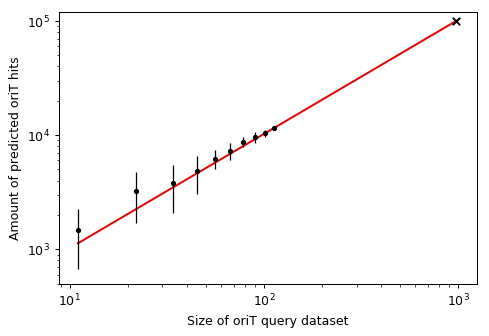

In [29]:
# Curve fit 

epsilon = 1
fit = []
col = 'num_orits'
xdata = df_dil.query_size.unique()
ydata = df_dil.groupby('query_size')[col].mean().values
ystd = df_dil.groupby('query_size')[col].std().values
ystd[-1], ystd[0] = [epsilon, epsilon]

popt, pcov = optimize.curve_fit(func1,xdata,ydata,sigma=ystd)
perr = np.sqrt(np.diag(pcov))
fit.append([popt,perr])

xdata2 = np.concatenate((xdata[1:],[200,300,500,1000]))
points = [100000]

plt.scatter(xdata,ydata,color='k',marker='o',s=10)
plt.errorbar(xdata,ydata,yerr=ystd,
             color='k',marker='o',elinewidth=1,fmt='none')
    
plt.plot(xdata2, func1(xdata2, *popt), 'r-',zorder=0)
plt.scatter(func1_inv(points, *popt),
            points,color='k',marker='x')

xerr=[func1_inv(points, *(popt + 1.96*perr/np.sqrt(10))),
      func1_inv(points, *(popt - 1.96*perr/np.sqrt(10)))]
plt.plot(xerr,[points,points],
             color='k',linewidth=1)
print(func1_inv(points, *popt),
      xerr
     )

# plotting the confidence intervals
bound_upper = func1(xdata2, *(popt + 1.96*perr/np.sqrt(10)))
bound_lower = func1(xdata2, *(popt - 1.96*perr/np.sqrt(10)))
plt.fill_between(xdata2, bound_lower, bound_upper,
             color = 'black', alpha = 0.15)

#plt.title('$R^2$ = '+str(metrics.r2_score(ydata,func1(xdata2, *popt))))

plt.xscale('log')
plt.yscale('log')
plt.ylim([500,120000])
plt.xlabel('Size of oriT query dataset')
plt.ylabel('Amount of predicted oriT hits')
plt.show()


4940.987605365489 [3547.6512774491202, 7002.862026021444]


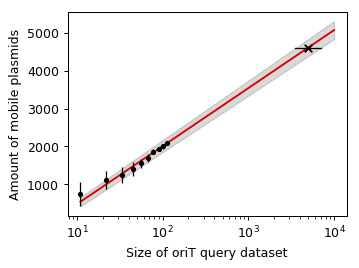

3101.294913710494 [2491.336309745659, 3890.787038543127]


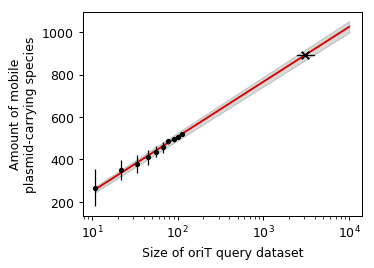

415.2886483222467 [327.7278303195488, 532.0201928022857]


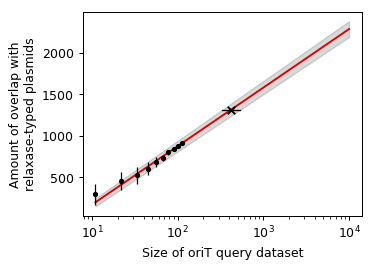

In [30]:
#_ = get_fit_results(func1,func1_inv)

xdata2 = np.concatenate((xdata[1:],[200,300,500,1000,2000,3000,5000,10000]))
ylabels = ['Amount of mobile plasmids',
           'Amount of mobile\nplasmid-carrying species',
           'Amount of overlap with\nrelaxase-typed plasmids']
points = [4602,893,1309]
k = 0

for col in ['num_plasmids',
            'num_species',
            'overlap_relax']:
    xdata = df_dil.query_size.unique()[1:] # drop zero
    ydata = df_dil.groupby('query_size')[col].mean().values[1:]
    ystd = df_dil.groupby('query_size')[col].std().values[1:]
    ystd[-1] = epsilon
    
    _ = get_fit_results(func1,func1_inv)
               
    k+=1
